evaluation on simplebooll5. validation score > 89%

In [1]:
import numpy
import pandas
from matplotlib import pyplot

from data.dataimport import import_data
import data.tree
from encoders.baseencoder import AbstractEncoder
from data.tree import Node

In [2]:
ENCODER_PKL = "../rnnsupervisedencoder-largeSimpleBoolean5.pkl"
VALIDATION_DATA = "../expressions-synthetic/split/largeSimpleBoolean5-validationset.json.gz"
DATA = VALIDATION_DATA

In [3]:
encoder = AbstractEncoder.load(ENCODER_PKL)

In [4]:
data = import_data(DATA)

In [5]:
def flatten_data(data):
    flat = []
    for key, class_ in data.items():
        for item in [class_['original']] + class_['noise']:
            flat.append({
                'eq_class': key,
                'expression': item
            })
    return flat
    
flat = flatten_data(data)

In [6]:
def set_encoding(encoder, flat):
    for item in flat:
        item['encoding'] = encoder.get_encoding(item['expression'])

set_encoding(encoder, flat)

Compiling Methods...
Compilation Finished...


In [7]:
def get_false():
    literal = "a"
    false = Node("Start", ("child",), "False")
    and_ = Node("And", ("left", "right"), "False", parent=false)
    false.set_children_for_property("child", [and_])
    literal_node = Node(literal, (), literal, parent=and_)
    and_.set_children_for_property("right", [literal_node])
    not_literal_node = Node("Not", ("child",), "Not({})".format(literal), parent=and_)
    literal_node_2 = Node(literal, (), literal, parent=not_literal_node)
    not_literal_node.set_children_for_property("child", [literal_node_2])
    and_.set_children_for_property("left", [not_literal_node])
    return list('(~{})&{}'.format(literal, literal)), false


print(get_false()[0])
print(str(get_false()[1]))

['(', '~', 'a', ')', '&', 'a']
-Start (False)
| \+child
|   \-And (False)
|     |+left
|     | \-Not (Not(a))
|     |   \+child
|     |     \-a (a)
|     \+right
|       \-a (a)



In [8]:
print(encoder.dataset_extractor.convert_tree_to_array(get_false()[1]))

TreeArrayRepresentation(terminal_idx=array([0, 1], dtype=int32), terminal_types=array([4, 4], dtype=int32), current_idx=array([2, 3, 4], dtype=int32), children_idxs=array([[ 1, -1],
       [ 2,  0],
       [ 3, -1]], dtype=int32), node_types=array([ 7,  3, 13], dtype=int32), num_nodes=5, eq_symbol=array(353, dtype=int32))


In [9]:
false_encoding = encoder.get_encoding(get_false())
print(false_encoding)


[-0.05260513 -0.00044746  0.04525001 -0.06157264 -0.00188046  0.36537558
  0.09976053  0.05204848 -0.23780778  0.08532621 -0.0228723  -0.02241857
 -0.04955533 -0.01390181  0.00938051  0.03112916 -0.19621707 -0.29946646
  0.02736039  0.06212078  0.2329437   0.06782116 -0.09762092  0.0086074
 -0.05211248  0.02665711  0.06885847  0.01408929 -0.0252952   0.05633501
 -0.11335017 -0.02359352  0.01245142 -0.03537644 -0.04661969  0.04746287
 -0.19517879  0.00144276 -0.17191605 -0.08180853  0.12777746 -0.0216901
  0.06097023 -0.07738505  0.05765972 -0.09061714  0.04844485 -0.08126201
  0.0794521  -0.17091013 -0.00827959 -0.01486147 -0.00117874  0.0524045
 -0.07889993  0.2792431  -0.04980036 -0.15386842 -0.40302074 -0.09696799
 -0.00703054 -0.31308216  0.03352482  0.05213499]


In [10]:
def set_dist_to_false(false_encoding, flat):
    def dist(x,y):   
        return numpy.sqrt(numpy.sum((x-y)**2))
    
    for item in flat:
        item['dist'] = dist(item['encoding'], false_encoding)
set_dist_to_false(false_encoding, flat)

In [11]:
def make_table(flat):
    return [{'eq_class': item['eq_class'],
             'expression': item['expression'][0],
             'dist': item['dist']} for item in flat]
table = make_table(flat)

In [12]:
pandas.set_option('max_rows', 700)
df = pandas.DataFrame(table)
df

,dist,eq_class,expression
0,1.034676,"And(e, f, g)","[e, &, (, g, &, f, )]"
1,1.243350,"Or(c, d, e)","[(, d, |, c, ), |, e]"
2,1.205207,"And(b, h)","[(, ~, (, ~, h, ), ), &, b]"
3,1.233226,"And(b, h)","[~, (, ~, (, b, &, h, ), )]"
4,1.242820,"And(b, h)","[b, &, (, h, &, b, )]"
5,1.264999,"Or(b, e, j)","[b, |, (, j, |, e, )]"
6,1.157068,"And(d, f)","[f, &, (, ~, (, ~, d, ), )]"
7,1.114102,"And(d, f)","[d, &, (, ~, (, ~, f, ), )]"
8,1.089719,"And(d, f)","[f, &, (, d, &, f, )]"
9,1.250437,"And(c, d)","[(, c, &, d, ), &, c]"


In [13]:
@numpy.vectorize
def bucketise(num):
    BUCKET_NUM = 20
    return numpy.floor(num / 2 * BUCKET_NUM)

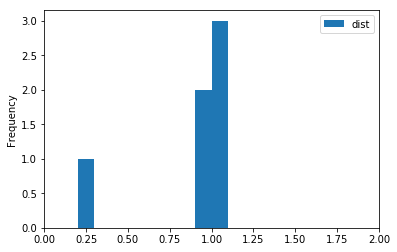

In [14]:
df[df.eq_class == 'False'].plot.hist(xlim=(0, 2), bins=numpy.linspace(0, 2, 21))

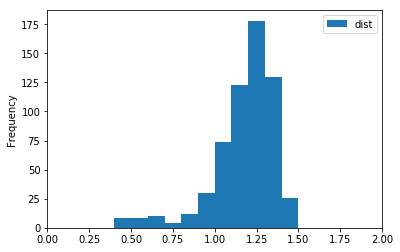

In [15]:
df[df.eq_class != 'False'].plot.hist(xlim=(0, 2), bins=numpy.linspace(0, 2, 21))